In [688]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from typing import List
sb.set()

# Exploratory Data Analysis Functions

## clean_up_dataset()
- input: Dataframe
- returns: clean up Dataframe
- description: Function cleans up the dataset such as
    - remove 0 price
- remarks: function will perform the following
    - assign column with the correct datatypes
    - removal rows with 0 value for the following columns
        - price
        - num_subscribers
        - num_lectures
        - content_length_min

In [689]:
def clean_up_dataset(dataframe: pd.DataFrame) -> pd.DataFrame:
    # total_rows = dataframe.shape[0]
    # print(f"Total samples: {total_rows}")
    
    # Assign the features to the correct datatype
    # better still if this is done in yaml to avoid hardcoding
    # dataframe['id'] = dataframe['id'].astype(int)
    # dataframe['language'] = dataframe['language'].astype('category')
    # dataframe['last_update_date'] = pd.to_datetime(dataframe['last_update_date'])
    # dataframe['num_comments'] = dataframe['num_comments'].astype(int)
    # dataframe['published_time'] = pd.to_datetime(dataframe['published_time'])
    # dataframe['num_reviews'] = dataframe['num_reviews'].astype(int) 

    dataframe['num_subscribers'] = dataframe['num_subscribers'].astype(int)
    dataframe['num_lectures'] = dataframe['num_lectures'].astype(int)
    dataframe['content_length_min'] = dataframe['content_length_min'].astype(int)
    dataframe['category'] = dataframe['category'].astype('category')
    dataframe['subcategory'] = dataframe['subcategory'].astype('category')
    dataframe['language'] = dataframe['language'].astype('category')
    dataframe['instructor_name'] = dataframe['instructor_name'].astype('category')
    # print("[BEFORE]")
    # for column in dataframe.columns:
    #     print(f"{column}: {type(column)} -> {(dataframe[column] == 0).sum()}")
    # print()
    
    #remove price = 0
    # dataframe = dataframe[
    #     (dataframe['price'] > 10) & 
    #     (dataframe['num_subscribers'] > 10000) &
    #     (dataframe['num_lectures'] > 10) & 
    #     (dataframe['content_length_min'] > 200) 
    #     # (dataframe['avg_rating'] > 3.0)
    # ]



    dataframe = dataframe[
        (dataframe['price'] > 0) & 
        (dataframe['num_subscribers'] > 0)
        # (dataframe['num_lectures'] > 10) & 
        # (dataframe['content_length_min'] >)
    ]

    # df_instructors = pd.DataFrame(dataframe, columns=['instructor_name'])
    # duplicate_instructors = df_instructors.pivot_table(columns=['instructor_name'], aggfunc='size')
    # print(f"Duplicated instructors: \n{duplicate_instructors}")
    
    print(f"Duplicated instructors: \n{dataframe['instructor_name'].value_counts(ascending=False)}")
    
    # total_duplicated_ids = dataframe[dataframe.duplicated('id', keep=False)]
    # print(f"Course with duplicated ids: {len(total_duplicated_ids)}")
    #add condition if there is duplicates

    # display the null values for each column
    # print(dataframe.isnull().sum())
    for column in dataframe.columns:
        print(f"{column}: {type(column)} -> {dataframe[column].dtype}, {dataframe[column].isnull().sum()}")

        # if dataframe[column].isnull().sum() == 0:
        #     continue
        
        # if pd.api.types.is_datetime64_dtype(dataframe[column]):
        #     print(f"is_datetime64")
        #     dataframe[column].fillna(value="NoUpdates")


    # print("[AFTER]")
    # for column in dataframe.columns:
    #     print(f"{column}: {type(column)} -> {(dataframe[column] == 0).sum()}")
    # print()
    
    return dataframe

## generate_numerical_eda_visualization()
- inputs: 
    - dataframe
    - List of catergorical features/columns which are numerical types
    - plot title
- returns: None
- description: generates box, histo and violin plot for every numerical features (column) of the dataset
- remakrs: None

In [690]:
def generate_numerical_eda_visualization(
        dataframe: pd.DataFrame,
        catergorical_column: List[str],
        plot_title: str
    ):
    
    numerical_dataframe = dataframe.select_dtypes(include=['int64', 'float64'])
    numerical_dataframe = numerical_dataframe.drop(columns=catergorical_column)

    total_features = len(numerical_dataframe.columns)
    figure, axes = plt.subplots(
        total_features, 
        3, 
        figsize=(24,4.8*total_features)
    )
    count = 0
    
    # figure.suptitle(plot_title, fontsize=10)
    axes[0, 1].set_title(plot_title)

    for column in numerical_dataframe.columns:
        sb.boxplot(data=numerical_dataframe[column], orient='h', ax=axes[count,0])
        sb.histplot(data=numerical_dataframe[column], ax=axes[count,1])
        sb.violinplot(data=numerical_dataframe[column], orient='h', ax=axes[count,2])
        count = count + 1

## get_outlier_samples()
- inputs: Dataframe
- returns: Series of outliers based on supplied dataframe
- description: identify the outliers based on the supplied dataframe
- remakrs: None

In [691]:
def get_outlier_samples(dataframe: pd.DataFrame) -> pd.core.series.Series:

    q1 = dataframe.quantile(0.25)
    q3 = dataframe.quantile(0.75)
    interquartile_range = q3-q1

    lower_whisker = q1-1.5*interquartile_range
    upper_whisker = q3+1.5*interquartile_range
    outliers: pd.core.series.Series = ((dataframe < lower_whisker) | (dataframe > upper_whisker))

    return outliers

## print_feature_outliers()
- inputs:
    - Dataframe
    - List of catergorical features/columns which are numerical types
- returns: None
- description: prints number of outliers for every numerical features/column
- remarks: None

In [692]:
def print_feature_outliers(
        dataframe: pd.DataFrame, 
        catergorical_column: List[str]
    ):

    numerical_dataframe = dataframe.select_dtypes(include=['int64', 'float64'])
    numerical_dataframe = numerical_dataframe.drop(columns=catergorical_column)

    for column in numerical_dataframe.columns:

        outliers = sum(get_outlier_samples(numerical_dataframe[column]))
        print(f"[{column}] total outliers: {outliers}")

## remove_outliers()
- inputs:
    - Dataframe
    - List of catergorical features/columns which are numerical types
- returns: Dataframe with outliers removed
- description: Function remove **UNION** outlier of the dataset. In other words remove the entire row containing outliers
- remarks: None

In [693]:
def remove_outliers(
        dataframe: pd.DataFrame, 
        catergorical_column: List[str]
    ) -> pd.DataFrame:

    numerical_dataframe = dataframe.select_dtypes(include=['int64', 'float64'])
    numerical_dataframe = numerical_dataframe.drop(columns=catergorical_column)

    union_outliers = (get_outlier_samples(numerical_dataframe)).any(axis=1)
    # print(f"Total 'UNION' outliers: {sum(union_outliers)}")
    dataframe_with_outliers_removed: pd.DataFrame = dataframe[~union_outliers].reset_index(drop=True)
    return dataframe_with_outliers_removed

## generate_categorical_count_visualization()
- inputs: Dataframe
- returns: None
- description: generates categorical plot for every catergorical features (column) of the dataset
- remakrs: None

In [694]:
def generate_categorical_count_visualization(dataframe: pd.DataFrame):
    
    categorical_dataframe = dataframe.select_dtypes(include=['category'])

    for column in categorical_dataframe.columns:
        category_total_types = len(dataframe[column].value_counts())        
        sb.catplot(y=column, data=categorical_dataframe, kind="count", height=category_total_types)

## generate_categorical_eda_visualization()
- inputs: 
    - dataframe
    - y_axis: numerical feature
    - x_axis: catergorical feature
    - plot title
- returns: None
- description: generates categorical plot for every catergorical features (column) of the dataset
- remarks: None

In [695]:
def generate_categorical_eda_visualization(
        dataframe: pd.DataFrame,
        y_axis: str,
        x_axis: str,
        plot_title: str
    ):

    # category_total_types = len(dataframe[x_axis].value_counts()) 
    figure = plt.figure(figsize=(20,8))
    figure.suptitle(plot_title)
    figure.tight_layout()
    sb_plot = sb.boxplot(y=y_axis, x=x_axis, data=dataframe, order=dataframe.groupby(x_axis)[y_axis].median().sort_values().index)
    sb_plot.set_xticklabels(sb_plot.get_xticklabels(), rotation=40, ha='right')

## generate_numerical_heatmap()
- inputs: 
    - dataframe
    - List of catergorical features/columns which are numerical types
    - plot title
- returns: None
- description: generates heatmap for every numerical features (column) of the dataset
- remarks: None

In [696]:
def generate_numerical_heatmap(
        dataframe: pd.DataFrame,
        catergorical_column: List[str],
        plot_title: str
    ):
    
    numerical_dataframe = dataframe.select_dtypes(include=['int64', 'float64'])
    numerical_dataframe = numerical_dataframe.drop(columns=catergorical_column)

    figure = plt.figure(figsize=(13, 13))
    figure.suptitle(plot_title)
    sb.heatmap(numerical_dataframe.corr(), vmin = -1, vmax = 1, linewidths = 1,
            annot = True, fmt = ".2f", annot_kws = {"size": 18}, cmap = "RdBu")

## generate_categorical_based_on_numerical_feature_heatmap
- inputs: 
    - dataframe
    - y_axis: numerical feature
    - x_axis: catergorical feature
    - numerical_feature: the numerical feature to associate with different type of x and y axis
    - plot title
- returns: None
- description: generates categorical plot for every catergorical features (column) of the dataset
- remarks: None

In [697]:
def generate_categorical_based_on_numerical_feature_heatmap(
       dataframe: pd.DataFrame,
       y_axis: str,
       x_axis: str,
       numerical_feature: str,
       plot_title: str
    ):

    total_means = dataframe.groupby([y_axis, x_axis]).mean().loc[:, numerical_feature]

    # Display the TOP numerical feature in each pair type -- top 20
    print(total_means.reset_index().sort_values(numerical_feature, ascending=False).head(20).round(2))


    x_axis_total_types = len(dataframe[x_axis].value_counts())
    y_axis_total_types = len(dataframe[y_axis].value_counts()) 
    figure = plt.figure(figsize=(x_axis_total_types, y_axis_total_types))
    figure.suptitle(plot_title)
    figure.tight_layout()
    sb_plot = sb.heatmap(total_means.unstack(), linewidths = 1,
           annot = True, fmt = ".0f", annot_kws = {"size": 18}, cmap = "BuGn")
    sb_plot.set_xticklabels(sb_plot.get_xticklabels(), rotation=90, ha='right')

# Exploratory Data Analysis
- Objective: Perform EDA on dataset while ensure that all function is working fine
- Motivation of Analysis: The type course catergory will impact the number of subscribers, price and average rating 

In [698]:
if __name__ == "__main__":
    DatasetRaw = pd.read_csv("../../dataset/Course_info.csv")
    DatasetRaw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209734 entries, 0 to 209733
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  209734 non-null  int64  
 1   title               209734 non-null  object 
 2   is_paid             209734 non-null  bool   
 3   price               209734 non-null  float64
 4   headline            209707 non-null  object 
 5   num_subscribers     209734 non-null  int64  
 6   avg_rating          209734 non-null  float64
 7   num_reviews         209734 non-null  int64  
 8   num_comments        209734 non-null  int64  
 9   num_lectures        209734 non-null  int64  
 10  content_length_min  209734 non-null  int64  
 11  published_time      209734 non-null  object 
 12  last_update_date    209597 non-null  object 
 13  category            209734 non-null  object 
 14  subcategory         209734 non-null  object 
 15  topic               208776 non-nul

In [699]:
if __name__ == "__main__":
    # removing 
    # 'id' cause doesn't have any significant importance to EDA
    # 'instructor_name' cause there is NULL value
    # 'published_time' cause its time series
    # 'last_update_date' cause there is null value and not so simeple to do EDA
    # 'num_reviews' cause doesnt seem to have any impact given we have average rating
    # 'num_comments' cause doesnt seem to have any impact given we have average rating
    # 'subcategory' have yet to decide if there is any need due to large number of types 
    # 'language' have yet to decide if this matter at the time of doing this EDA 
    ExtractedDataset = pd.DataFrame(
        DatasetRaw[[
            'price', 
            'num_subscribers', 
            'avg_rating', 
            'num_lectures',
            'content_length_min', 
            'category',
            'subcategory'
        ]]
    )

In [700]:
if __name__ == "__main__":
    CleanDataset = clean_up_dataset(ExtractedDataset)
    CleanDataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178546 entries, 0 to 209729
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   price               178546 non-null  float64 
 1   num_subscribers     178546 non-null  int64   
 2   avg_rating          178546 non-null  float64 
 3   num_lectures        178546 non-null  int64   
 4   content_length_min  178546 non-null  int64   
 5   category            178546 non-null  category
 6   subcategory         178546 non-null  category
dtypes: category(2), float64(2), int64(3)
memory usage: 8.7 MB


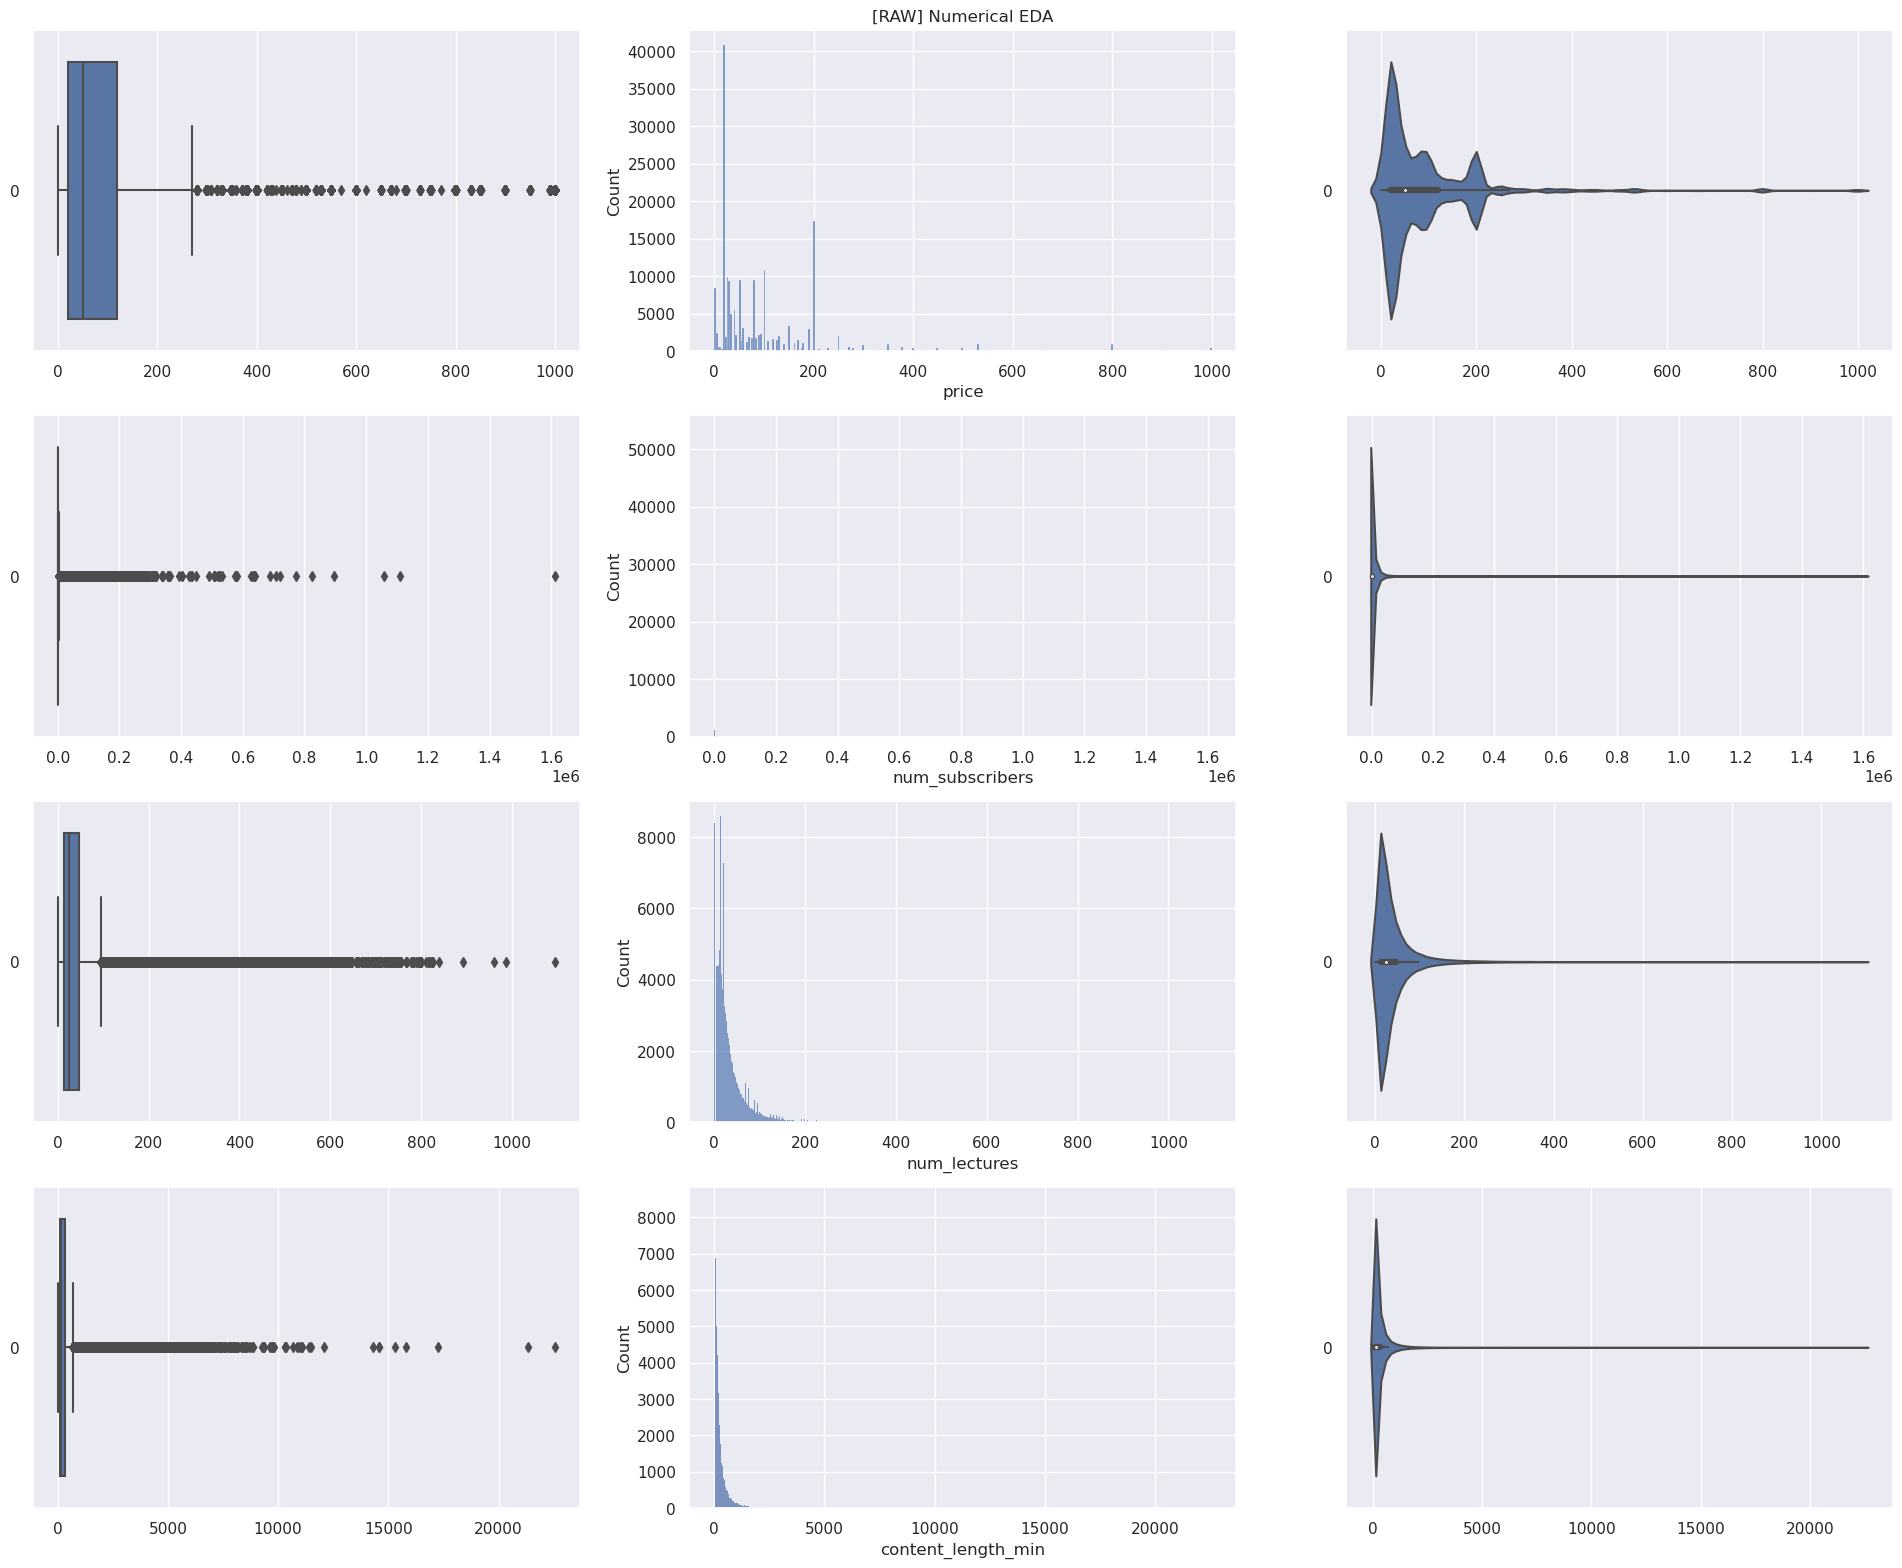

In [701]:
if __name__ == "__main__":
    categorical_data_in_numeric = ['avg_rating']
    generate_numerical_eda_visualization(CleanDataset, categorical_data_in_numeric, "[RAW] Numerical EDA")

In [702]:
if __name__ == "__main__":
    print_feature_outliers(CleanDataset, categorical_data_in_numeric)

[price] total outliers: 7785
[num_subscribers] total outliers: 26845
[num_lectures] total outliers: 14691
[content_length_min] total outliers: 15778


In [703]:
if __name__ == "__main__":
    RemovedOutlierDataset = remove_outliers(CleanDataset, categorical_data_in_numeric)

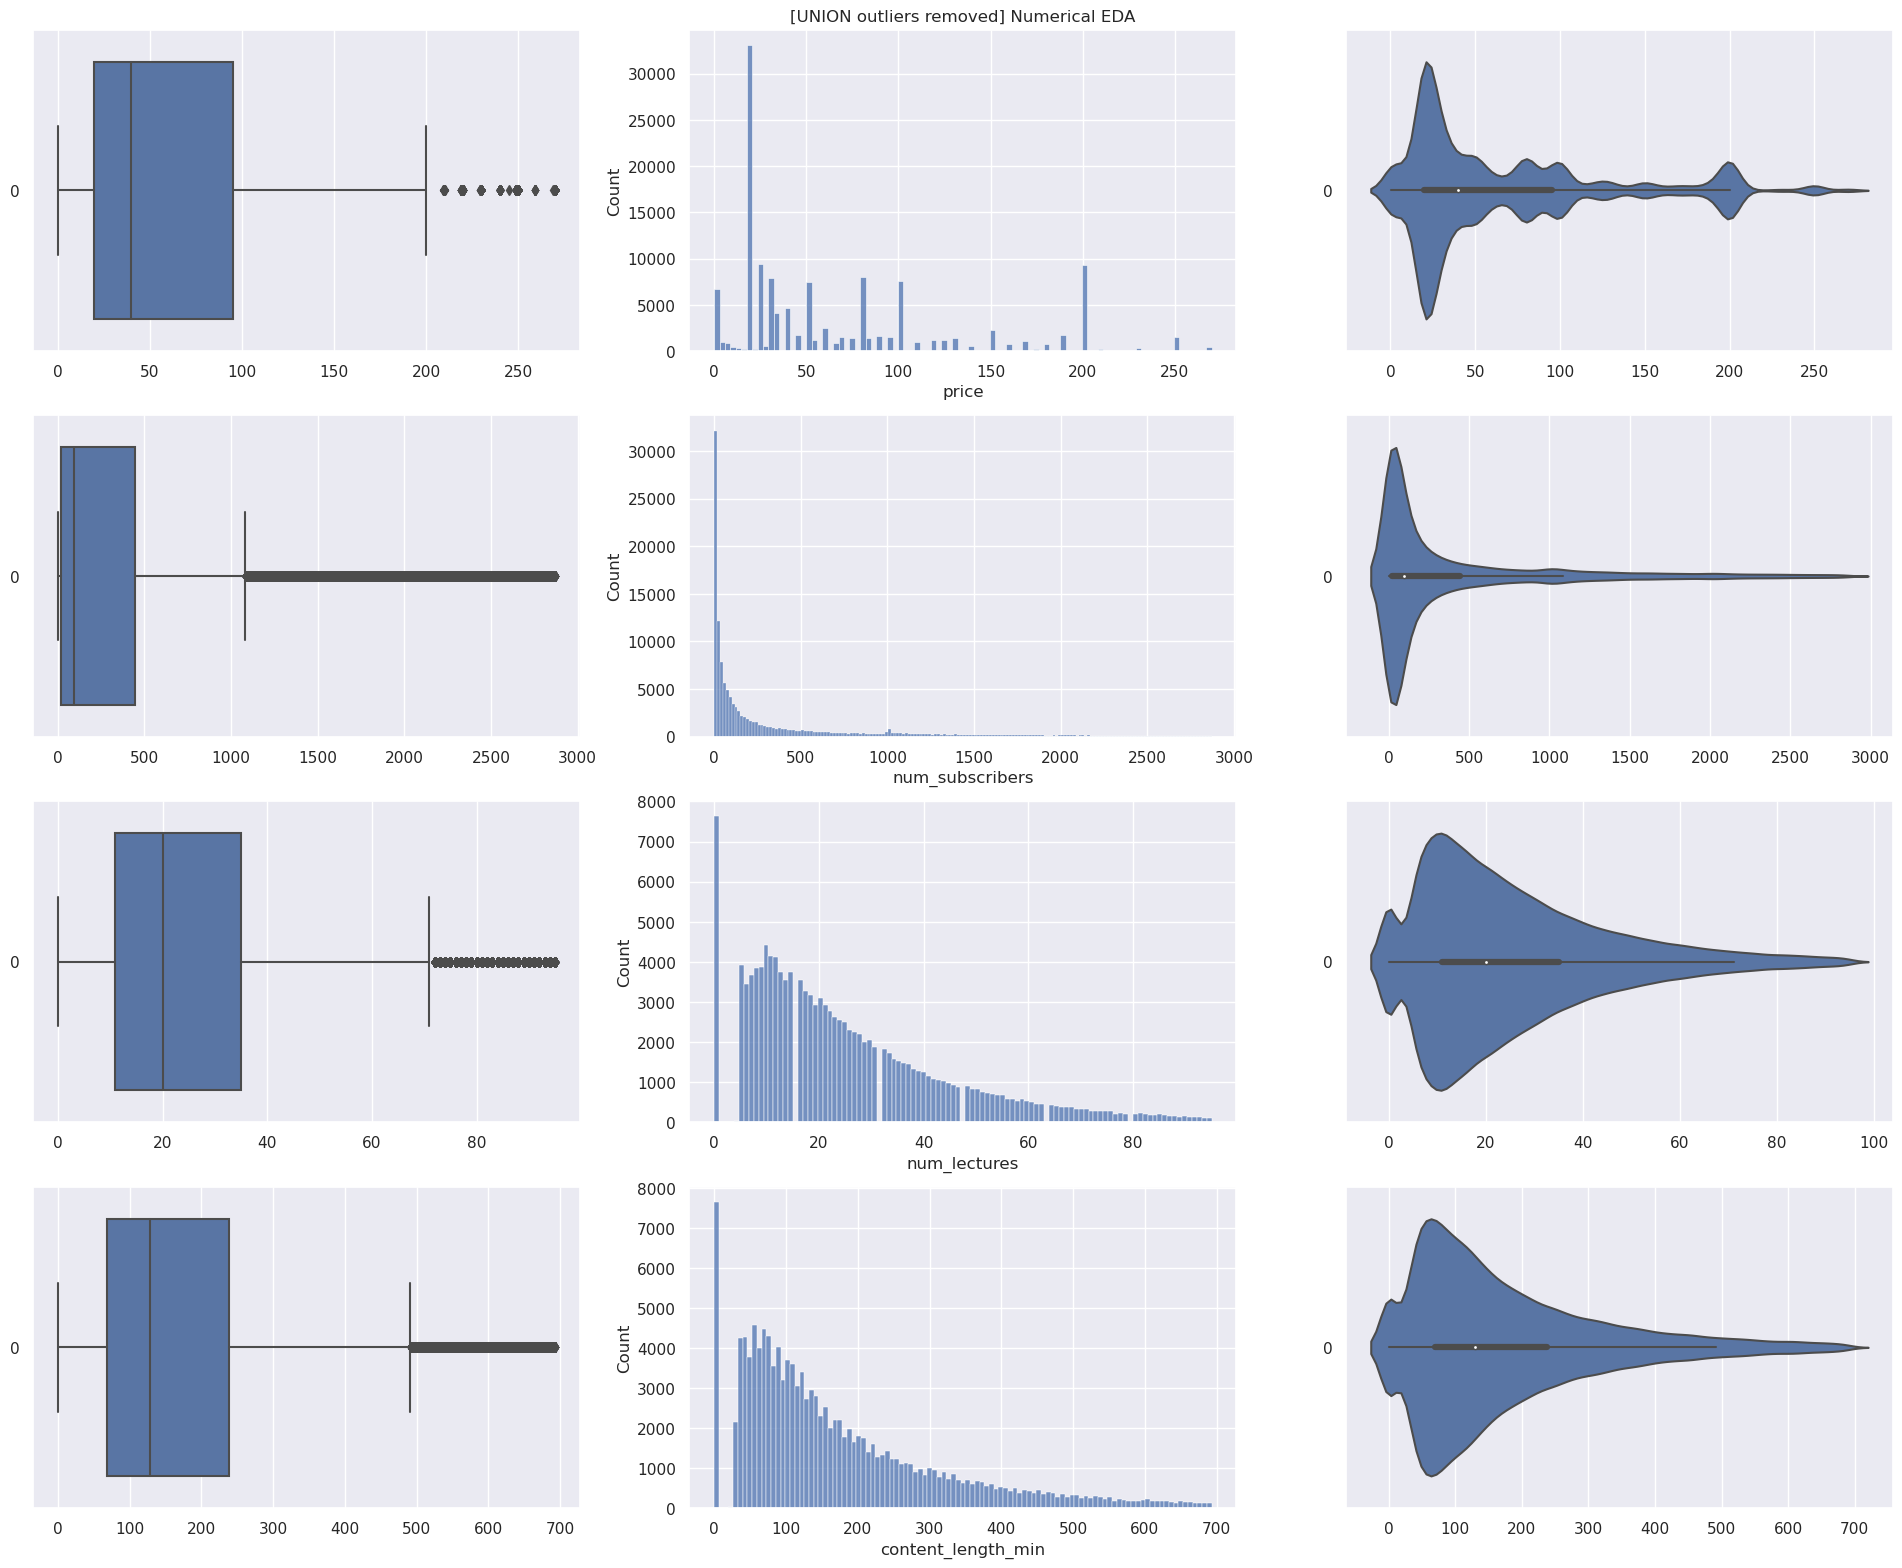

In [704]:
if __name__ == "__main__":
    generate_numerical_eda_visualization(RemovedOutlierDataset, categorical_data_in_numeric, "[UNION outliers removed] Numerical EDA")

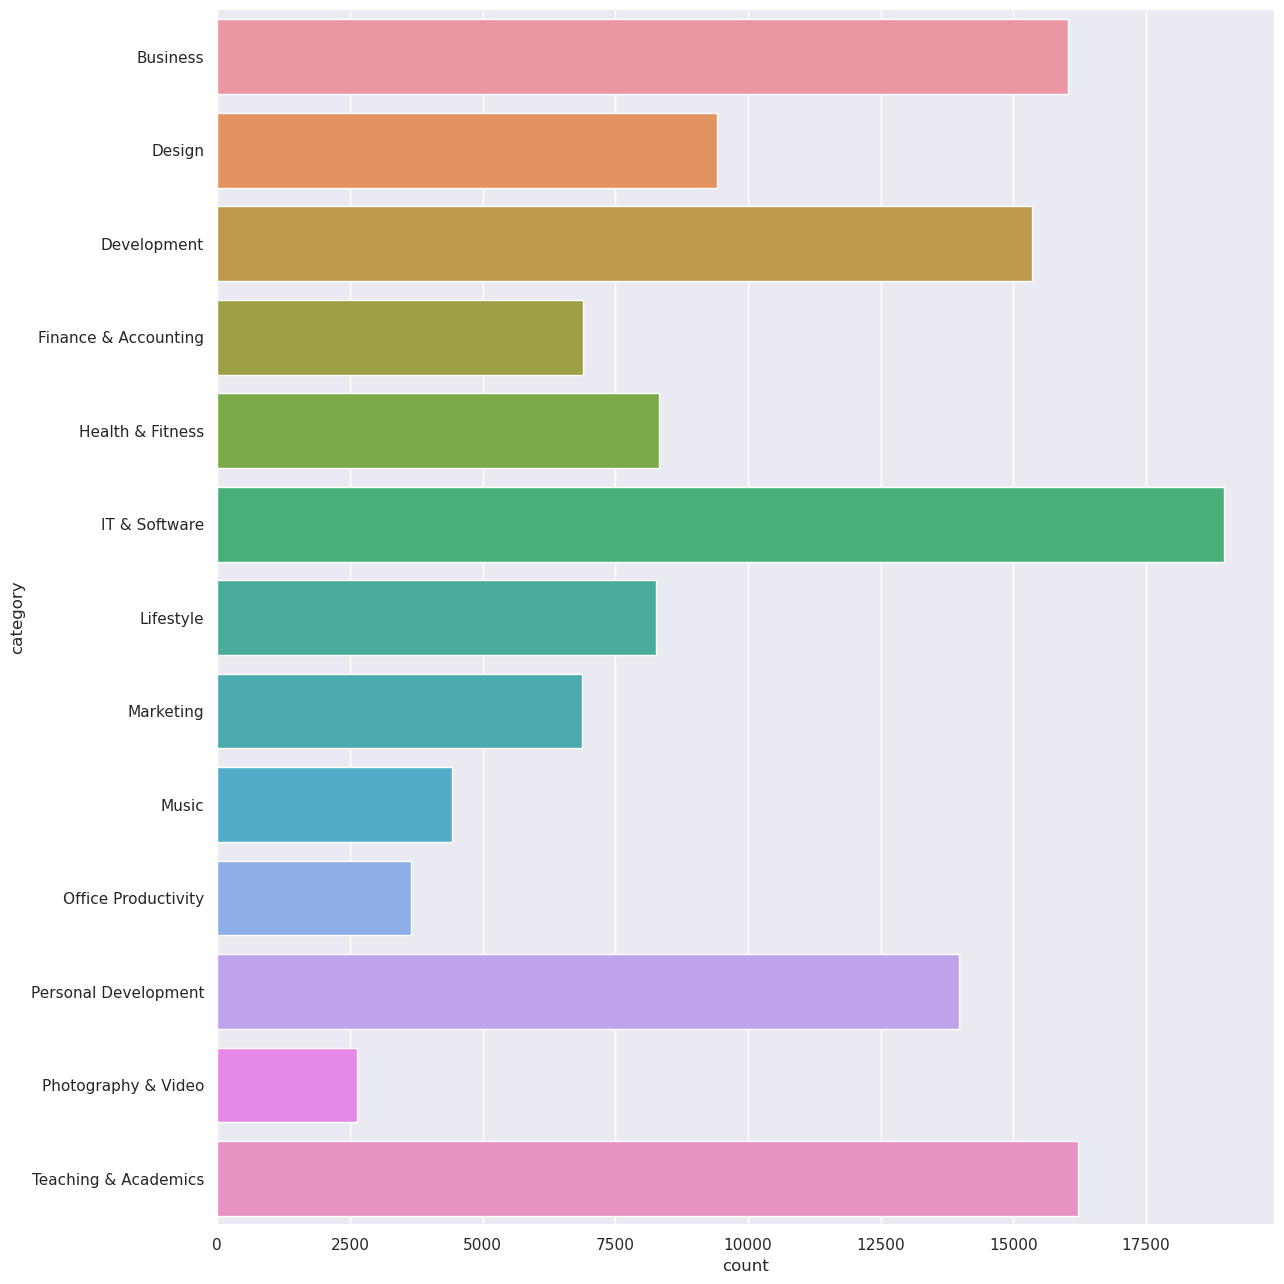

In [705]:
if __name__ == "__main__":
    generate_categorical_count_visualization(RemovedOutlierDataset)

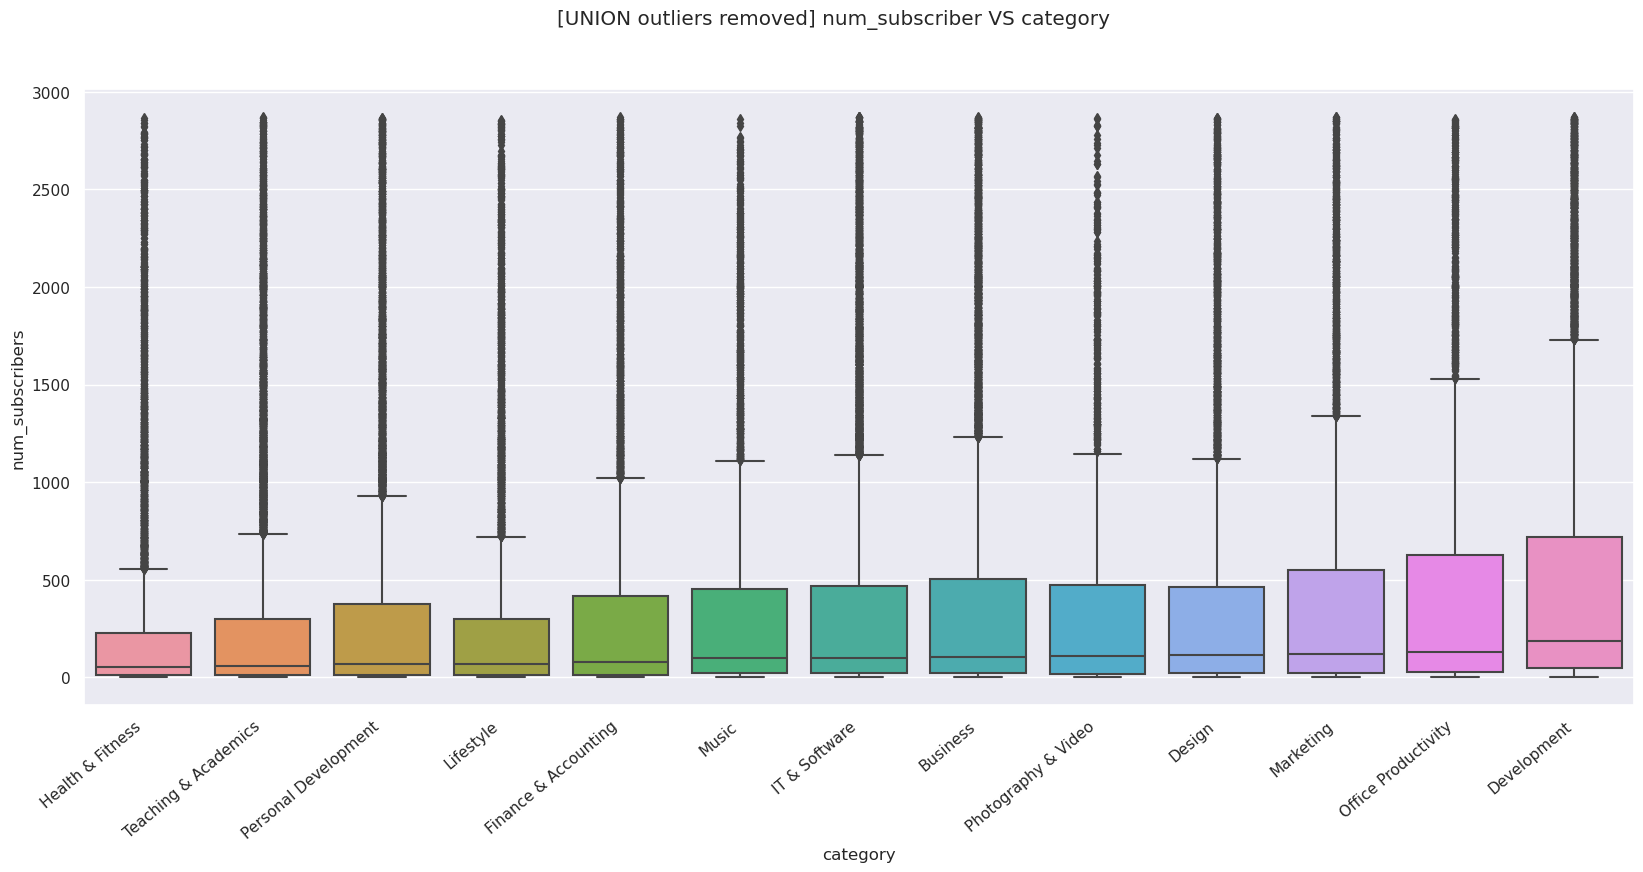

In [706]:
if __name__ == "__main__":
    generate_categorical_eda_visualization(RemovedOutlierDataset, 'num_subscribers', 'category', '[UNION outliers removed] num_subscriber VS category')

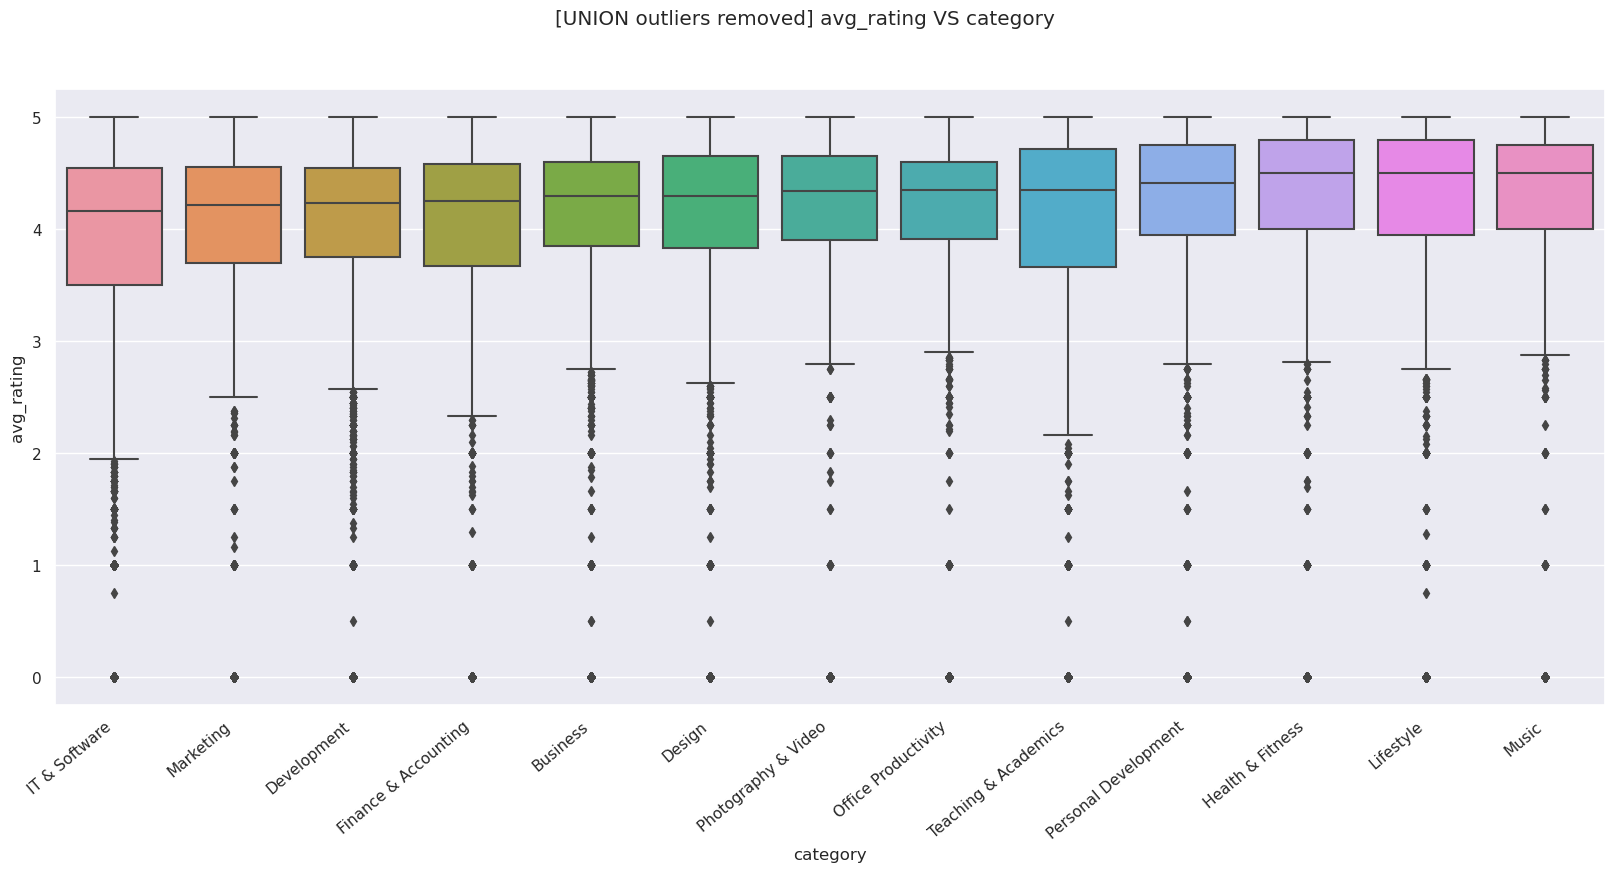

In [707]:
if __name__ == "__main__":
    generate_categorical_eda_visualization(RemovedOutlierDataset, 'avg_rating', 'category', '[UNION outliers removed] avg_rating VS category')

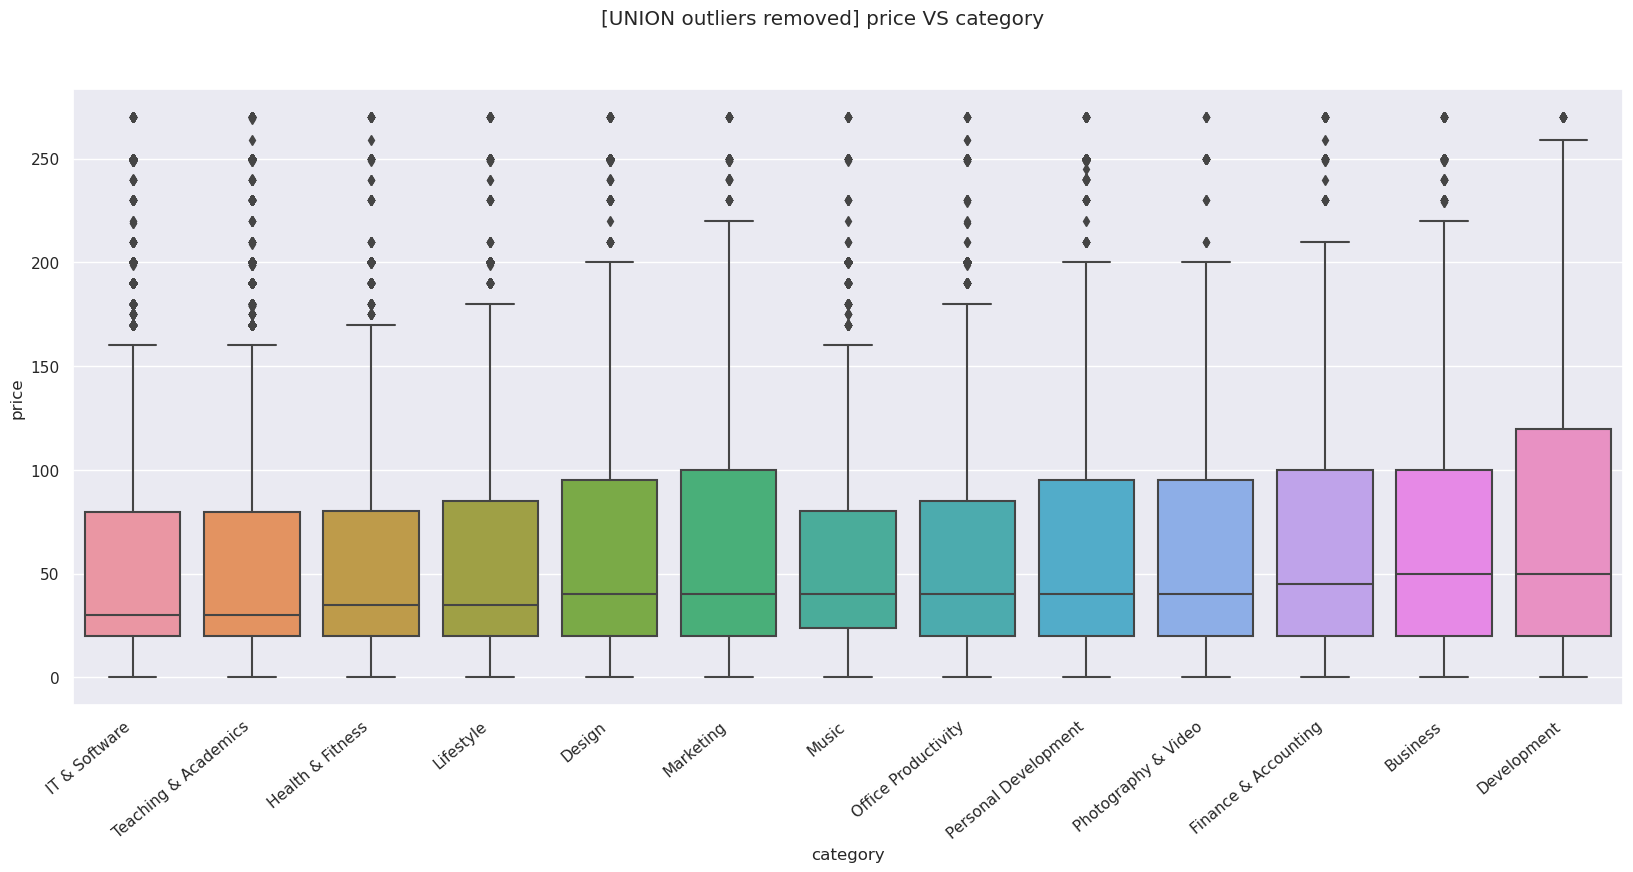

In [708]:
if __name__ == "__main__":
    generate_categorical_eda_visualization(RemovedOutlierDataset, 'price', 'category', '[UNION outliers removed] price VS category')

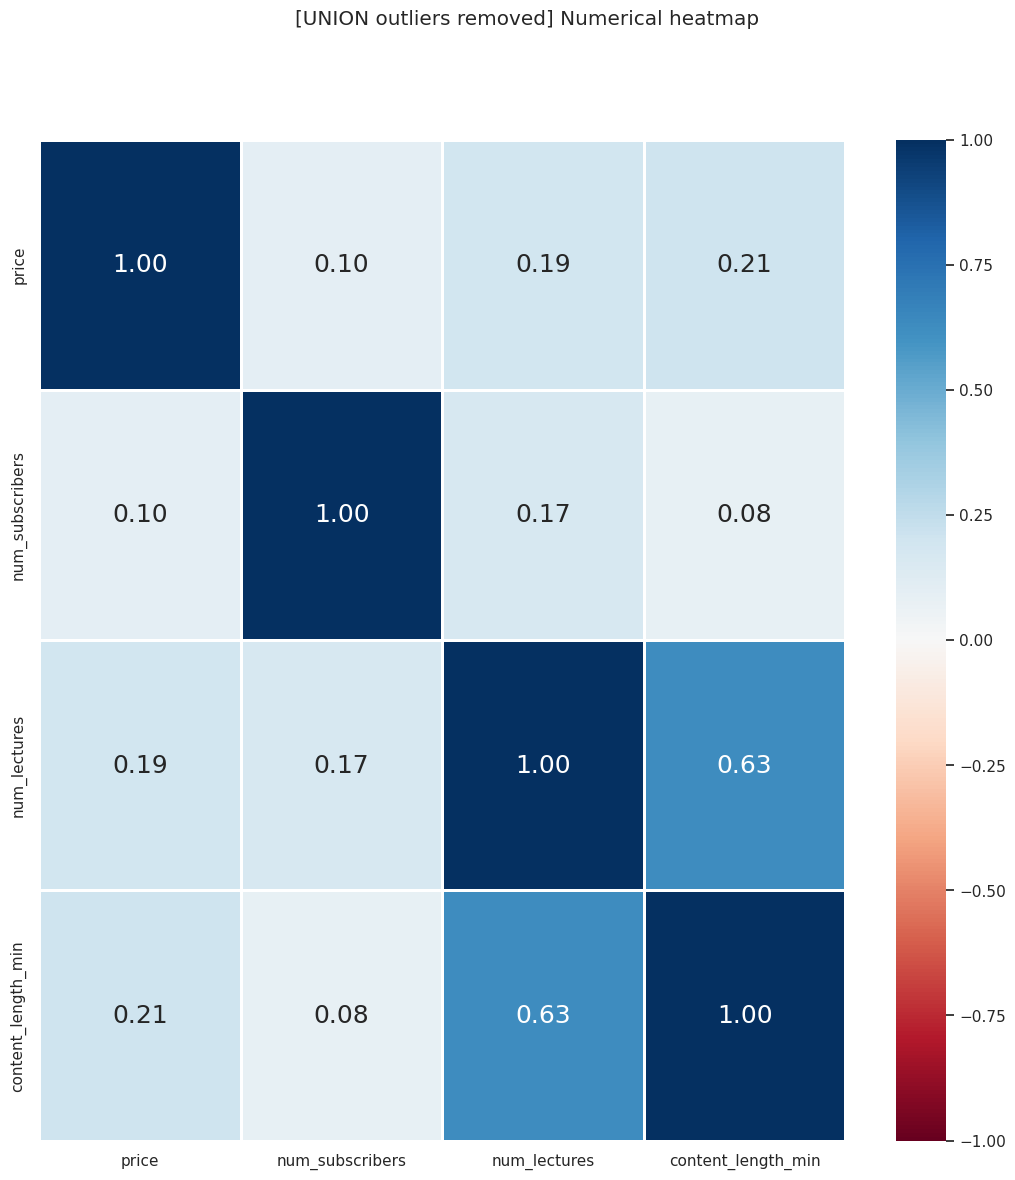

In [709]:
if __name__ == "__main__":
    generate_numerical_heatmap(RemovedOutlierDataset, categorical_data_in_numeric, "[UNION outliers removed] Numerical heatmap")

                  category                        subcategory  avg_rating
808              Lifestyle                 Esoteric Practices        4.19
1173   Office Productivity                              Apple        4.17
165                 Design                        Game Design        4.09
1209   Office Productivity                             Google        4.08
1110                 Music                     Music Software        4.05
817              Lifestyle                             Gaming        4.05
1453   Photography & Video                Digital Photography        4.02
376            Development                   Software Testing        4.01
8                 Business  Business Analytics & Intelligence        4.01
1109                 Music                   Music Production        4.01
1090                 Music                        Instruments        4.01
1166                 Music                              Vocal        4.00
578       Health & Fitness        Mart

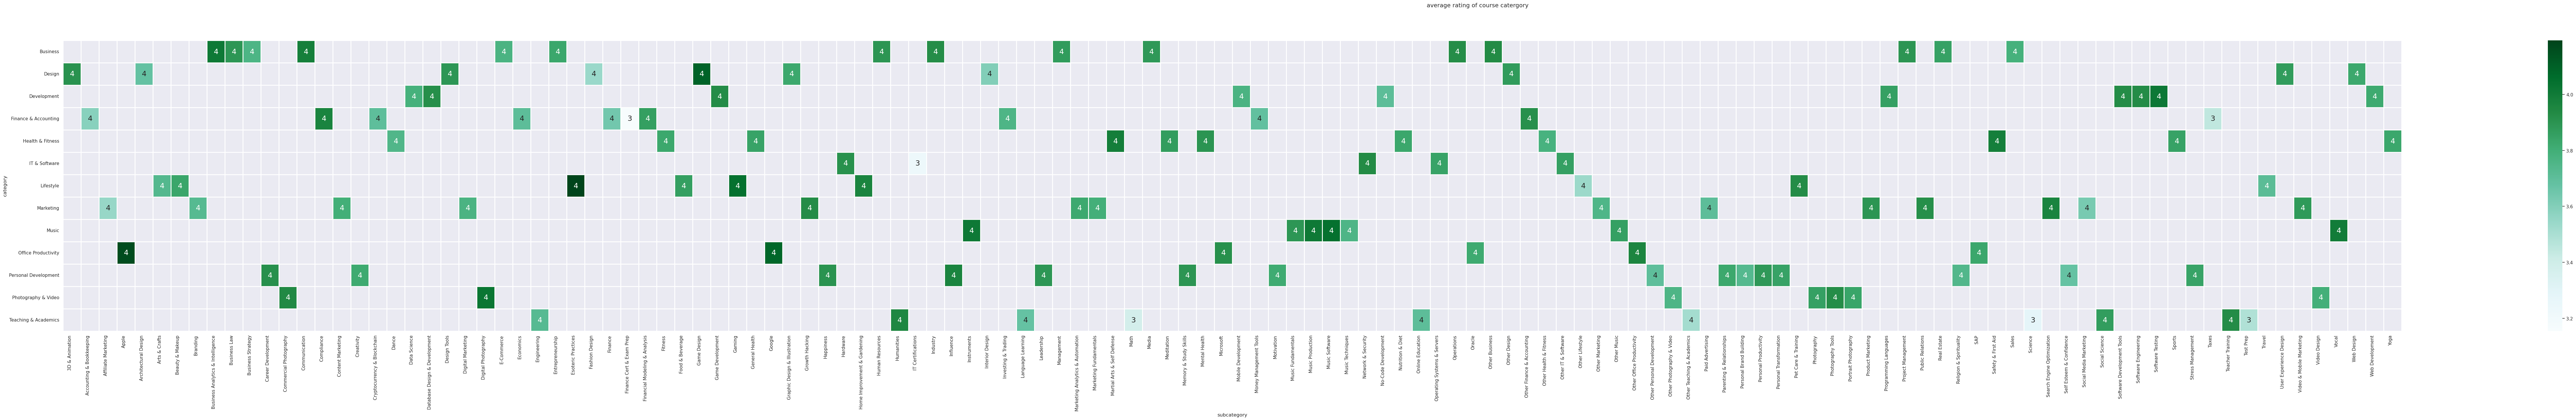

In [710]:
if __name__ == "__main__":
    generate_categorical_based_on_numerical_feature_heatmap(RemovedOutlierDataset, 'category', 'subcategory', 'avg_rating', 'average rating of course catergory')

                  category                        subcategory  num_subscribers
280            Development      Database Design & Development           607.52
376            Development                   Software Testing           604.91
8                 Business  Business Analytics & Intelligence           575.02
257                 Design                         Web Design           557.06
374            Development         Software Development Tools           537.85
253                 Design             User Experience Design           530.19
375            Development               Software Engineering           527.03
1362  Personal Development              Memory & Study Skills           516.62
912              Marketing                Affiliate Marketing           514.72
1020             Marketing         Search Engine Optimization           509.95
361            Development              Programming Languages           509.28
1276   Office Productivity                          

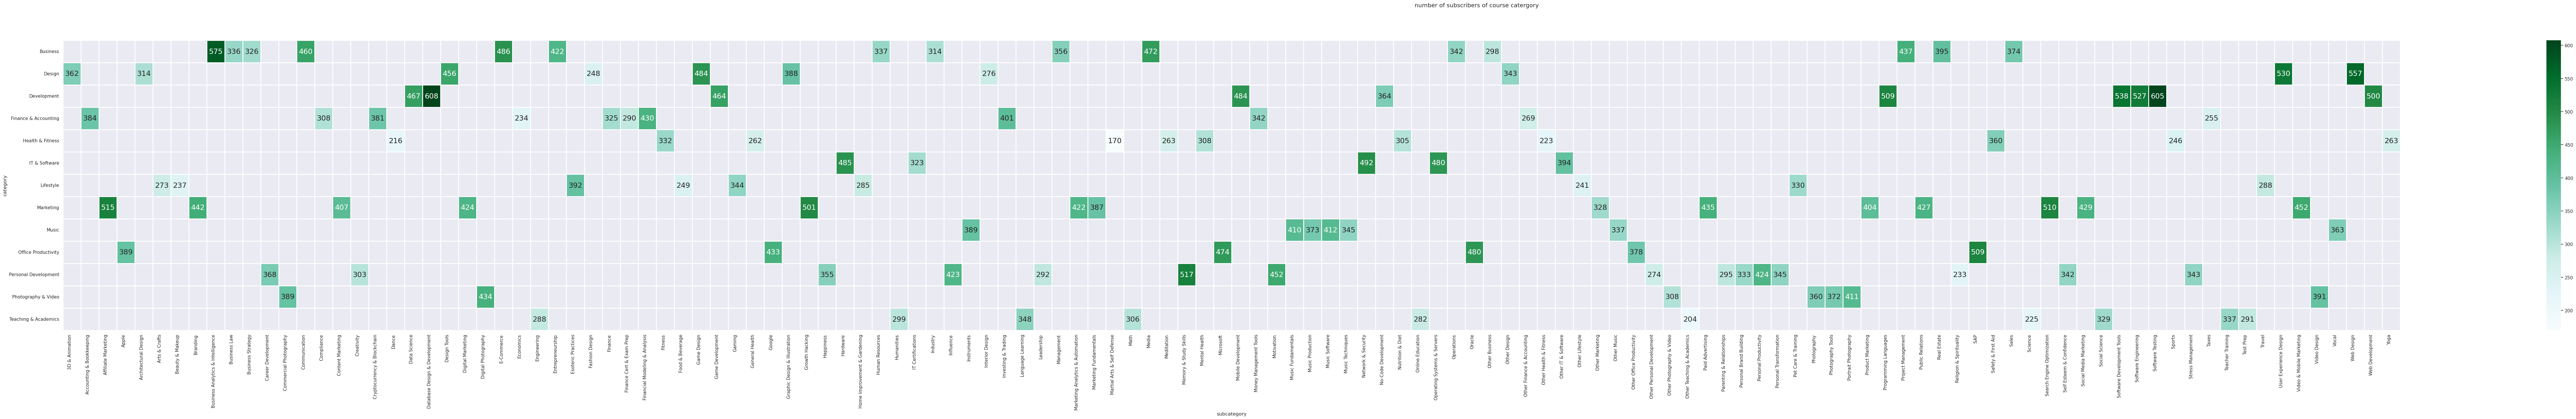

In [711]:
if __name__ == "__main__":
    generate_categorical_based_on_numerical_feature_heatmap(RemovedOutlierDataset, 'category', 'subcategory', 'num_subscribers', 'number of subscribers of course catergory')

                  category                        subcategory  price
951              Marketing                     Growth Hacking  90.33
442   Finance & Accounting                Investing & Trading  87.65
1529   Photography & Video               Portrait Photography  84.64
280            Development      Database Design & Development  84.29
24                Business                         E-Commerce  83.89
407   Finance & Accounting        Cryptocurrency & Blockchain  82.77
279            Development                       Data Science  81.81
296            Development                   Game Development  81.58
808              Lifestyle                 Esoteric Practices  80.88
104               Business                        Real Estate  78.51
1010             Marketing                  Product Marketing  78.44
1001             Marketing                   Paid Advertising  77.95
361            Development              Programming Languages  77.75
8                 Business  Busine

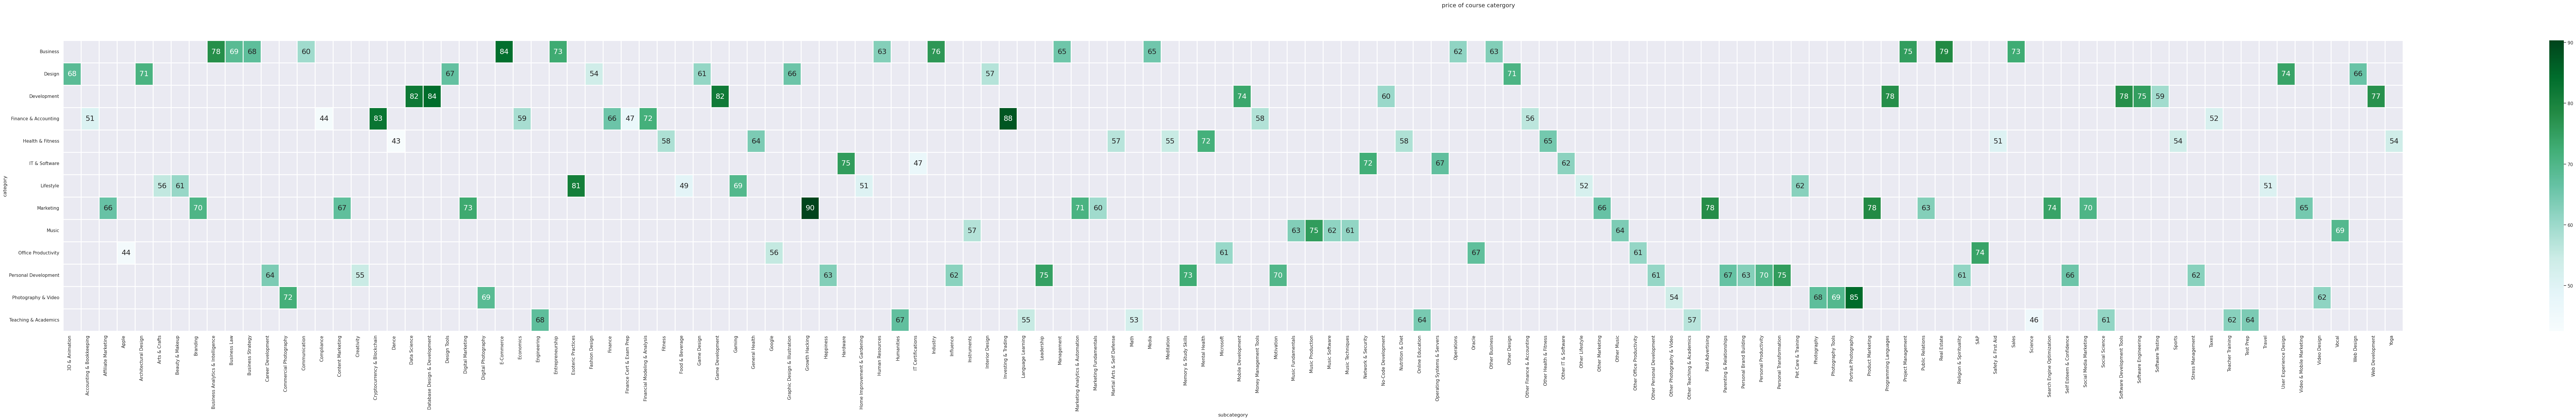

In [712]:
if __name__ == "__main__":
    generate_categorical_based_on_numerical_feature_heatmap(RemovedOutlierDataset, 'category', 'subcategory', 'price', 'price of course catergory')